# Artificial Neural Network for stable points

## Import libraries and preprocessing

In [1]:
# read & manipulate data
import keras_tuner as kt
import pandas as pd 
import numpy as np
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU') # Disable GPU since slow on my machine

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, Dense
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# visualisations
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.style.use('fivethirtyeight')

# misc
import random as rn

# load the dataset
import sys
sys.path.append("../scripts")

# manual parameters
RANDOM_SEED = 420
TRAINING_SAMPLE = 15000
VALIDATE_SIZE = 0.2

# setting random seeds for libraries to ensure reproducibility
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [2]:
df = pd.read_pickle("../data/processed/SRD_Lysekil.pkl")
df = df[df['Status'] == 'Stable']

X = df.drop(['Status', 'SRD'], axis=1)
y = df[['Time', 'SRD']]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2)

# Standard scaling the data
scaler = StandardScaler()
cols = [col for col in X_train.columns if col != 'Time']
X_train[cols] = scaler.fit_transform(X_train[cols])
X_test[cols] = scaler.transform(X_test[cols])

# Need to reshape since the scaler expects a 2D array
y_train['SRD'] = scaler.fit_transform(y_train['SRD'].to_numpy().reshape(-1, 1))
y_test['SRD'] = scaler.transform(y_test['SRD'].to_numpy().reshape(-1, 1))

input_dim = X.drop('Time', axis=1).shape[1]
output_dim = y.drop('Time', axis=1).shape[1]

## Simple ANN with zero hidden layers

In [ ]:
def buildModel(optimizer='adam'):
    classifier = Sequential()

    classifier.add(Input(shape=(input_dim,)))    
    #classifier.add(Dense(units=128, activation='relu'))
    #classifier.add(Dense(units=128, activation='relu'))
    classifier.add(Dense(units=1, activation='linear'))
    
    classifier.compile(loss='mean_squared_error', 
                  optimizer=optimizer, 
                  metrics=['mean_squared_error'])
    
    return classifier

regressor = buildModel('adam')
History = regressor.fit(x=X_train.drop('Time', axis=1), 
                        y=y_train.drop('Time', axis=1),
                        batch_size=32, 
                        epochs=100, 
                        verbose=0)

In [ ]:
first_layer_weights = regressor.layers[0].get_weights()[0]

df = pd.DataFrame({'Feature': X.drop('Time', axis=1).columns,
                   'Coefficient': first_layer_weights.flatten()})

fig = go.Figure(data=[go.Bar(x=df['Feature'], y=df['Coefficient'])])  

fig.update_layout(
                xaxis_title="Feature",
                yaxis_title="Coefficient",
                height=400,
                width=800,
                legend=dict(
                            orientation="h",
                            yanchor="bottom",
                            y=1.02,
                            xanchor="right",
                            x=0.15
                        ),
                template="seaborn",
                margin=dict(l=0, r=20, t=20, b=10),
                )

In [ ]:
plt.plot(History.history['mean_squared_error'])
plt.title('Loss Function Over Epochs')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.show()

In [3]:
def plot_results(df_res):
    fig = go.Figure()

    fig.add_trace(
        go.Scatter(
            x=df_res["Time"], 
            y=df_res["Actual"], 
            mode='markers', 
            marker=dict(size=4),
            name='Actual',
        )
    )

    fig.add_trace(
        go.Scatter(
            x=df_res["Time"], 
            y=df_res["Predicted"], 
            mode='markers', 
            marker=dict(size=4),
            name='Prediction',
        )
    )

    fig.update_layout(title="Modelling the SRD using ANN", 
                    legend=dict(
                            orientation="h",
                            yanchor="bottom",
                            y=1.02,
                            xanchor="right",
                            x=0.3
                        ),
                    template="seaborn",
                    xaxis_title="Time", 
                    yaxis_title="Specific Reboiler Duty [MJ/kgCO2]")

    fig.show()

def prediction_df(model, scaler, X, y):
    y_pred = model.predict(X.drop('Time', axis=1))
    y_pred = scaler.inverse_transform(y_pred)
    
    y_inv = y.copy()
    y_inv['SRD'] = scaler.inverse_transform(y['SRD'].to_numpy().reshape(-1, 1))

    df_res = pd.DataFrame({'Time': y_inv['Time'], 
                           'Actual': y_inv['SRD'], 
                           'Predicted': y_pred.flatten()})
    df_res.sort_values('Time')
    
    rmse = mean_squared_error(df_res['Actual'], df_res['Predicted'], squared=False)
    print(f"Root Mean Squared Error: {rmse}")
    
    return df_res

In [4]:
df_train = prediction_df(regressor, scaler, X_train, y_train)
df_test = prediction_df(regressor, scaler, X_test, y_test)
#plot_results(df_res)

NameError: name 'regressor' is not defined

# Using Keras Tuner

WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.

WARNING:absl:There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.Adam`.

In [5]:
pkl_path = '/Users/junxingli/Desktop/master_thesis/data/processed/SRD_Lysekil.pkl'
tuner_path = '/Users/junxingli/Desktop/master_thesis/models/ann/'
proj_name = 'tune_hypermodel-V2'
best_model_path = tuner_path + proj_name + '/best_model'

In [ ]:
class MyHyperModel(kt.HyperModel):
    def build(self, hp): 
        hp_learning_rate = hp.Choice('learning_rate', 
                                      values=[1e-1, 1e-2, 1e-3, 1e-4])
            
        model = keras.Sequential()
        model.add(Input(shape=(input_dim,)))
        for i in range(hp.Int('num_layers', 1, 4)):
            model.add(Dense(units=hp.Int('units_' + str(i), 
                                         min_value=50, 
                                         max_value=150, 
                                         step=5),
                            activation='relu'))
        
        model.add(Dense(1, activation='linear'))
        
        # Select optimizer    
        optimizer = hp.Choice('optimizer', values=['adam', 'SGD', 'rmsprop'])
        if optimizer == 'adam':
            model.compile(
            optimizer=keras.optimizers.legacy.Adam(learning_rate=hp_learning_rate),
            loss='mean_squared_error',
            metrics=['mean_squared_error']
            )
        elif optimizer == 'SGD':
            model.compile(
            optimizer=keras.optimizers.legacy.SGD(learning_rate=hp_learning_rate),
            loss='mean_squared_error',
            metrics=['mean_squared_error']
            )
        elif optimizer == 'rmsprop':
            model.compile(
            optimizer=keras.optimizers.legacy.RMSprop(learning_rate=hp_learning_rate),
            loss='mean_squared_error',
            metrics=['mean_squared_error']
            )
        
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [32, 64, 128, 256]),
            **kwargs,
        )


In [ ]:
tuner = kt.Hyperband(
    MyHyperModel(),
    objective='val_mean_squared_error',
    max_epochs=1000,
    factor=3,
    overwrite=False,
    directory=tuner_path,
    project_name=proj_name)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', 
                                              patience=25)

tuner.search(X_train.drop('Time', axis=1),
             y_train.drop('Time', axis=1), 
             epochs=500, 
             validation_split=0.25, 
             callbacks=[stop_early])

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

History = best_model.fit(X_train.drop('Time', axis=1), 
                         y_train.drop('Time', axis=1), 
                         epochs=1000, 
                         callbacks=[tf.keras.callbacks.EarlyStopping(
                                    monitor='mean_squared_error', 
                                    patience=50)
                                    ],
                         validation_split=0)

best_model.save(best_model_path)

best_model.summary()
print(f"""{best_hps.values}
-------------------------------------
Model saved to {best_model_path}""")

In [ ]:
plt.plot(History.history['mean_squared_error'])
plt.title('Loss Function Over Epochs')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.show()

In [12]:
loaded_model = keras.models.load_model(best_model_path)
df_train = prediction_df(loaded_model, scaler, X_train, y_train)
df_test = prediction_df(loaded_model, scaler, X_test, y_test)

391/391 [==============================] - 0s 316us/step
Root Mean Squared Error: 0.03462274843528256
98/98 [==============================] - 0s 337us/step
Root Mean Squared Error: 0.03311499011257481


Freedman-Diaconis number of bins: 68


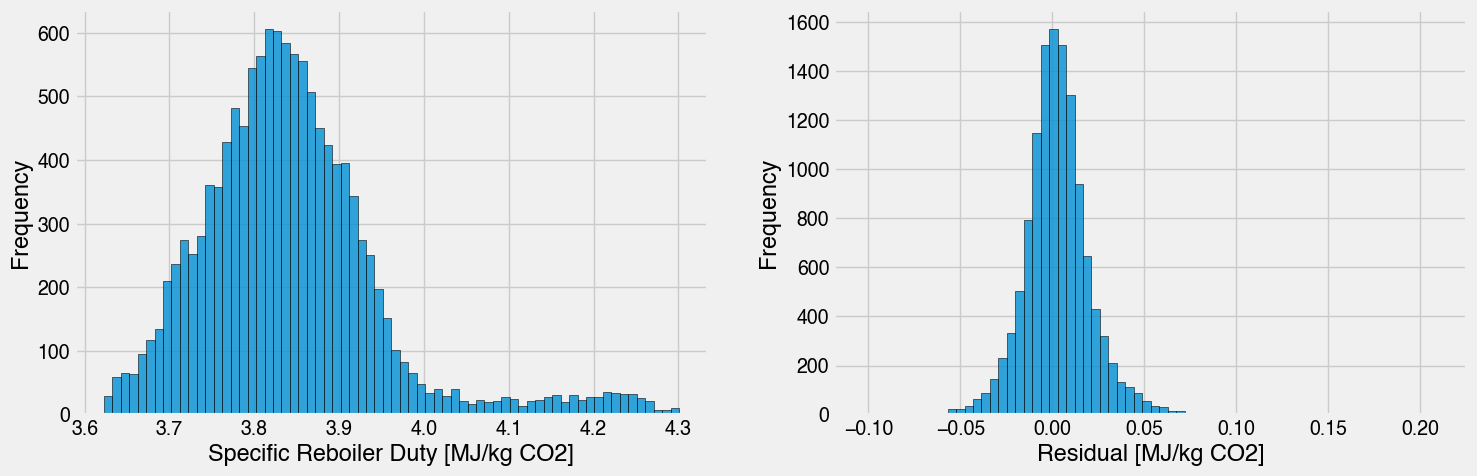

In [70]:
def generate_histograms(df):
    x = df['Actual']
    lower_percentile = np.percentile(x, 0.5)
    upper_percentile = np.percentile(x, 99.5)
    mask = (x > lower_percentile) & (x < upper_percentile)
    x_0_5 = x[mask.values].squeeze()
    x_0_5_res = x_0_5 - df['Predicted'][mask.values].squeeze()
    
    q25, q75 = np.percentile(x_0_5, [25, 75])
    bin_width = 2 * (q75 - q25) * len(x_0_5) ** (-1/3)
    bins = round((x_0_5.max() - x_0_5.min()) / bin_width)
    print("Freedman-Diaconis number of bins:", bins)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

    ax1.hist(x_0_5, bins=bins, edgecolor='black', alpha=0.8)
    ax1.set_xlabel('Specific Reboiler Duty [MJ/kg CO2]')
    ax1.set_ylabel('Frequency')

    ax2.hist(x_0_5_res, bins=bins, edgecolor='black', alpha=0.8)
    ax2.set_xlabel('Residual [MJ/kg CO2]')
    ax2.set_ylabel('Frequency')

    plt.show()
    
generate_histograms(df_train)

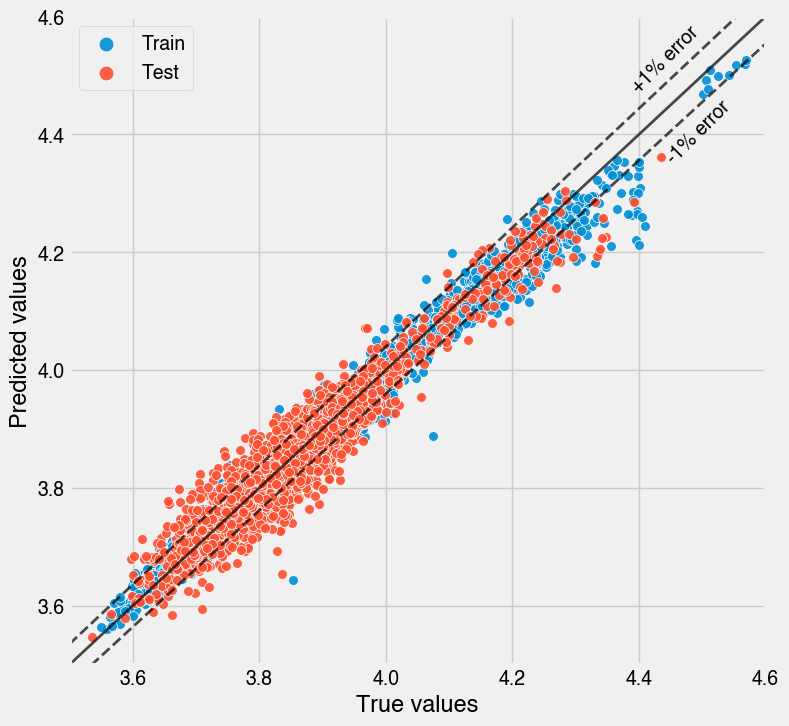

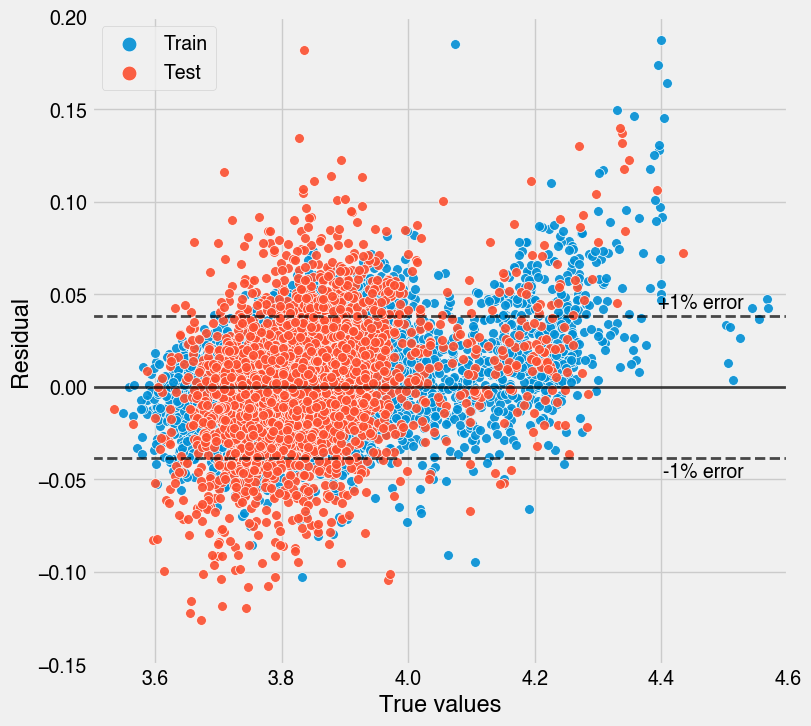

/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


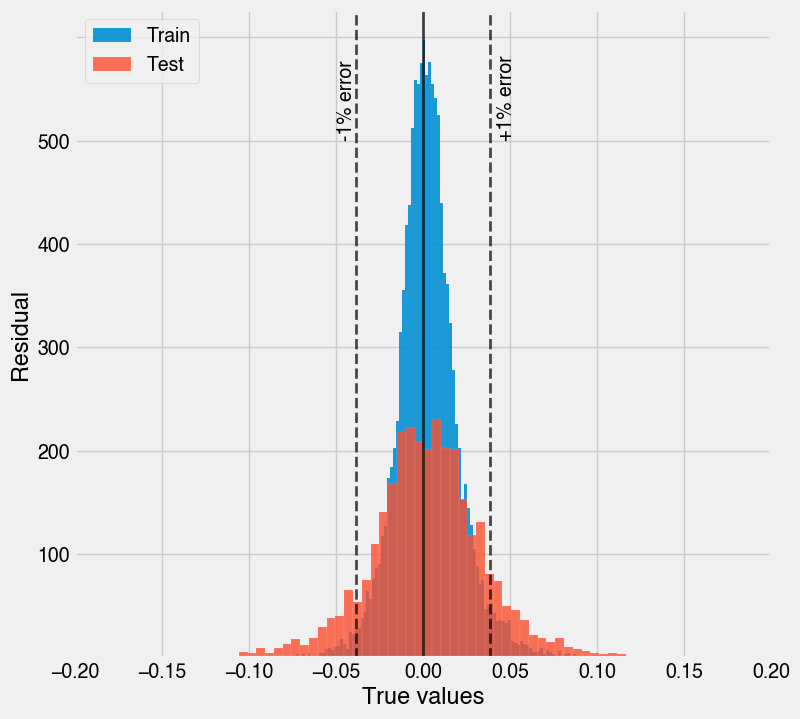

/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/XingsKernel/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

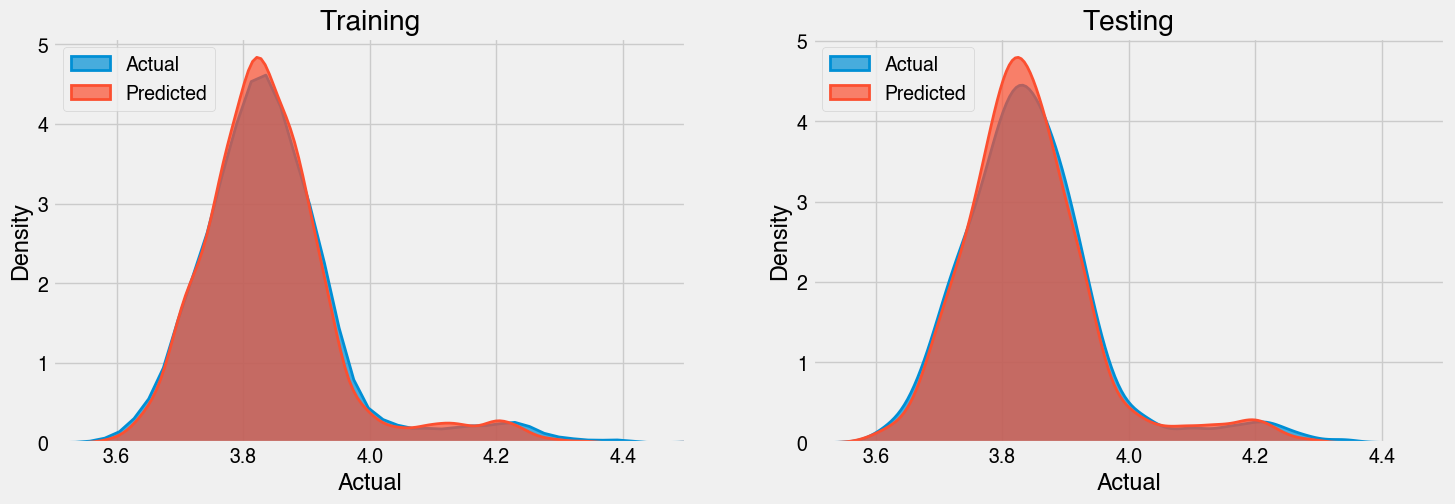

In [68]:
# Parity plot
limit = np.array([3.5, 4.6])

plt.figure(figsize=(8, 8))
sns.scatterplot(x=df_train['Actual'], y=df_train['Predicted'], label='Train', alpha=0.9, s=50)
sns.scatterplot(x=df_test['Actual'], y=df_test['Predicted'], label='Test', alpha=0.9, s=50)

plt.plot(limit, limit, color='black', alpha=0.7, linewidth=2)
plt.plot(limit, 1.01*limit, color='black', linestyle='--', alpha=0.7, linewidth=2)
plt.plot(limit, 0.99*limit, color='black', linestyle='--', alpha=0.7, linewidth=2)

plt.text(limit[1]-0.1, 1.01*limit[1]-0.18, '+1% error', verticalalignment='bottom', horizontalalignment='right', color='black', rotation=45)
plt.text(limit[1]-0.05, 0.99*limit[1]-0.09, '-1% error', verticalalignment='top', horizontalalignment='right', color='black', rotation=45)

plt.xlim(limit)
plt.ylim(limit)
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.legend(markerscale=1.5)

plt.savefig("../figs/ann/Parity_plot_ANN.pdf", format="pdf", bbox_inches='tight')
plt.show()


# Residuals plot
mean = df['SRD'].mean()

plt.figure(figsize=(8, 8))
sns.scatterplot(x=df_train['Actual'], y=df_train['Actual'] - df_train['Predicted'], label='Train', alpha=0.9, s=50)
sns.scatterplot(x=df_test['Actual'], y=df_test['Actual'] - df_test['Predicted'], label='Test', alpha=0.9, s=50)

plt.axhline(0, color='black', linestyle='-', alpha=0.7, linewidth=2)
plt.axhline(0.01*mean, color='black', linestyle='--', alpha=0.7, linewidth=2)
plt.axhline(-0.01*mean, color='black', linestyle='--', alpha=0.7, linewidth=2)

plt.text(limit[1]-0.07, 0.0105*mean, '+1% error', verticalalignment='bottom', horizontalalignment='right', color='black')
plt.text(limit[1]-0.07, -0.0105*mean, '-1% error', verticalalignment='top', horizontalalignment='right', color='black')

plt.xlim(limit)
plt.ylim(-0.15, 0.2)
plt.xlabel('True values')
plt.ylabel('Residual')
plt.legend(markerscale=1.5)

plt.savefig("../figs/ann/Residuals_plot_ANN.pdf", format="pdf", bbox_inches='tight')
plt.show()


# Residuals histogram plot
mean = df['SRD'].mean()
x_lim = np.array([-0.2, 0.2])

plt.figure(figsize=(8, 8))

ax = plt.gca()
yticks = ax.yaxis.get_major_ticks() 
yticks[0].label1.set_visible(False)

sns.histplot(df_train['Actual'] - df_train['Predicted'], label='Train', alpha=0.9)
sns.histplot(df_test['Actual'] - df_test['Predicted'], label='Test', alpha=0.8)

plt.text(0.011*mean, 500, '+1% error', verticalalignment='bottom', horizontalalignment='left', color='black', rotation=90)
plt.text(-0.01*mean, 500, '-1% error', verticalalignment='bottom', horizontalalignment='right', color='black', rotation=90)

plt.axvline(0, color='black', linestyle='-', alpha=0.7, linewidth=2)
plt.axvline(0.01*mean, color='black', linestyle='--', alpha=0.7, linewidth=2)
plt.axvline(-0.01*mean, color='black', linestyle='--', alpha=0.7, linewidth=2)

plt.xlim(x_lim)
plt.xlabel('True values')
plt.ylabel('Residual')
plt.legend(markerscale=1.5, loc='upper left')

plt.savefig("../figs/ann/ResidualHistogram_plot_ANN.pdf", format="pdf", bbox_inches='tight')
plt.show()

# Density plot
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

sns.kdeplot(df_train['Actual'], linewidth=2, alpha=0.7, fill=True, ax=axs[0], label='Actual')
sns.kdeplot(df_train['Predicted'], linewidth=2, alpha=0.7, fill=True, ax=axs[0], label='Predicted')
axs[0].legend(loc='upper left')
axs[0].set_xlim(3.5, 4.5)
axs[0].set_title('Training')

sns.kdeplot(df_test['Actual'], linewidth=2, alpha=0.7, fill=True, ax=axs[1], label='Actual')
sns.kdeplot(df_test['Predicted'], linewidth=2, alpha=0.7, fill=True, ax=axs[1], label='Predicted')
axs[1].legend(loc='upper left')
axs[1].set_xlim(3.5, 4.5)
axs[1].set_title('Testing')

plt.savefig("../figs/ann/KDE_plot_ANN.pdf", format="pdf", bbox_inches='tight')
plt.show()